In [2]:
import numpy as np
import pandas as pd
import urllib.request
import altair as alt
import seaborn as sns
import matplotlib

In [3]:
url1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url2 ='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url3= 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
urllib.request.urlretrieve(url1,'time_series_covid19_confirmed_global.csv')
urllib.request.urlretrieve(url2,'time_series_covid19_deaths_global.csv')
urllib.request.urlretrieve(url3,'time_series_covid19_recovered_global.csv')
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [4]:
dates = confirmed_df.columns[4:]
confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)
deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)
recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)

In [5]:
full_table = confirmed_df_long.merge(
  right=deaths_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)
full_table = full_table.merge(
  right=recovered_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])

In [6]:
full_table['Date'] = pd.to_datetime(full_table['Date'])

In [7]:
full_table['Recovered'] = full_table['Recovered'].fillna(0)

In [8]:
full_table.drop('Province/State', axis=1,inplace=True)
full_table.drop('Lat', axis=1,inplace=True)
full_table.drop('Long', axis=1,inplace=True)

In [9]:
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

In [10]:
full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

<ipython-input-10-b4242cc93c67>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()


In [11]:
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])
full_grouped = full_grouped.fillna(0)
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')
full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

<ipython-input-11-a740983a2d75>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']


In [12]:
full_grouped.to_csv('COVID-19-time-series-clean-complete.csv')
full_grouped = pd.read_csv('COVID-19-time-series-clean-complete.csv', parse_dates=['Date'])

In [14]:
def total_country_stats(country_name):
    stat_country = full_grouped[full_grouped['Country/Region'] == country_name]
    base = alt.Chart(stat_country).mark_bar().encode(x='monthdate(Date):O',).properties(width=500)
    red=alt.value('#f54242')
    print("Stats for "+country_name, end="\n")
    data_current=stat_country.tail(1)
    data_10=stat_country.tail(10)
    print("Total Confirmed: ",int(data_current['Confirmed'].mean()))
    print("Total Recovered: ",int(data_current['Recovered'].mean()))
    print("Total Death: ",int(data_current['Deaths'].mean()))
    print("Average Confirmed(Last 10 Days): ",int(data_10['New cases'].mean()))
    print("Average Recovered(Last 10 Days): ",int(data_10['New recovered'].mean()))
    print("Average Death(Last 10 Days): ",int(data_10['New deaths'].mean()))
    return base.encode(y='Confirmed').properties(title='Total Confirmed') | base.encode(y='Recovered').properties(title='Total Recovered')
    base.encode(y='Deaths').properties(title='Total Deaths') | base.encode(y='Active').properties(title='Total Active')

In [16]:
def daily_country_stats(country_name):
    stat_country = full_grouped[full_grouped['Country/Region'] == country_name]
    base = alt.Chart(stat_country).mark_bar().encode(x='monthdate(Date):O',).properties(width=500)
    red=alt.value('#f54242')
    print("Stats for "+country_name)
    data_current=stat_country.tail(1)
    print("Today Confirmed: ",int(data_current['New cases'].mean()))
    print("Today Recovered: ",int(data_current['New recovered'].mean()))
    print("Today Death: ",int(data_current['New deaths'].mean()))
    return base.encode(y='New cases').properties(title='New Confirmed') | base.encode(y='New recovered').properties(title='New Recovered')
    base.encode(y='New deaths').properties(title='New Deaths')

In [20]:
total_country_stats(input("Enter Country Name:"))

Enter Country Name:US
Stats for US
Total Confirmed:  38384360
Total Recovered:  0
Total Death:  633564
Average Confirmed(Last 10 Days):  149540
Average Recovered(Last 10 Days):  0
Average Death(Last 10 Days):  1137


alt.HConcatChart(...)

In [21]:
daily_country_stats(input("Enter Country Name:"))

Enter Country Name:US
Stats for US
Today Confirmed:  161331
Today Recovered:  0
Today Death:  1292


alt.HConcatChart(...)

In [25]:
def country_jointplots(country_name):
    stat_country = full_grouped[full_grouped['Country/Region'] == country_name]
    x='Total Death'
    y='Total Recovered'
    df = pd.DataFrame({'Total Death': stat_country['Deaths'], 'Total Recovered': stat_country['Recovered']})
    sns.jointplot(x,y, data=df,kind = 'kde')
    df = pd.DataFrame({'Total Active': stat_country['Active'], 'Total Recovered': stat_country['Recovered']})
    sns.jointplot('Total Active', 'Total Recovered', data=df,kind = 'kde')
    df = pd.DataFrame({'Total Active': stat_country['Active'], 'Total Death': stat_country['Deaths']})
    sns.jointplot('Total Active', 'Total Death', data=df,kind = 'kde')

Enter Country Name:US


c:\users\gobi\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\gobi\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\gobi\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

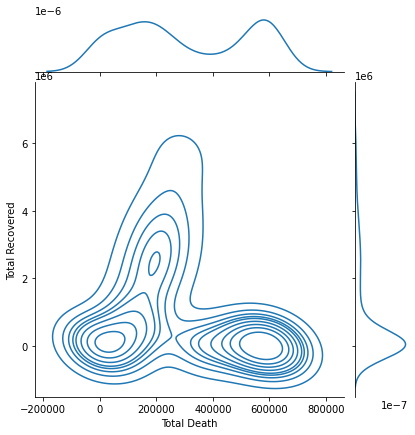

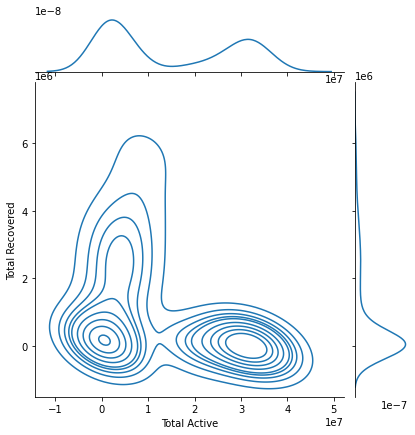

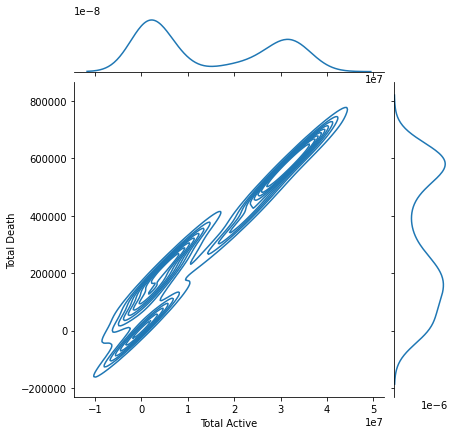

In [26]:
country_jointplots(input("Enter Country Name:"))

In [27]:
def multiple_countries(country_list):
  selected_countries = full_grouped[full_grouped['Country/Region'].isin(country_list)]
  return alt.Chart(selected_countries).mark_circle().encode(x='monthdate(Date):O',y='Country/Region',color='Country/Region',size=alt.Size('New cases:Q',scale=alt.Scale(range=[0, 1000]),legend=alt.Legend(title='Daily new cases'))).properties(width=800, height=300)

In [28]:
multiple_countries(input("Enter Countries to compare:").split())

Enter Countries to compare:India US Russia


alt.Chart(...)